E 0; L 2.302200; Tr_acc 0.112796; Te_acc 0.131725; T 2.349667
E 10; L 1.397529; Tr_acc 0.502605; Te_acc 0.512658; T 2.007557
E 20; L 1.074731; Tr_acc 0.622926; Te_acc 0.597903; T 1.968026
E 30; L 0.834794; Tr_acc 0.707964; Te_acc 0.627769; T 1.905861
E 40; L 0.619579; Tr_acc 0.781006; Te_acc 0.636472; T 1.988372
E 50; L 0.423345; Tr_acc 0.853169; Te_acc 0.636472; T 1.775405
E 60; L 0.261458; Tr_acc 0.911049; Te_acc 0.639636; T 2.012940
E 70; L 0.128912; Tr_acc 0.960510; Te_acc 0.632714; T 2.027008
E 80; L 0.023559; Tr_acc 0.997582; Te_acc 0.633307; T 1.945180
E 90; L 0.009535; Tr_acc 0.999848; Te_acc 0.637460; T 1.789721
Tr_acc 0.999940; Te_acc 0.638054


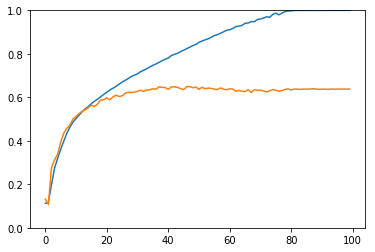

In [1]:
from mxnet import nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
from time import time
ctx = mx.gpu()


def load_cifar(route = '/home/sinyer/python/data/cifar-10-batches-py', train_num = 50000, test_num = 10000):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    train_pic = train_pic[:train_num].astype('float32')/255
    train_label = train_label[:train_num].astype('float32')
    test_pic = test_pic[:test_num].astype('float32')/255
    test_label = test_label[:test_num].astype('float32')
    return train_pic, train_label, test_pic, test_label

train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label), batch_size, shuffle=False)


def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

def net(X):
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=W1.shape[2:], num_filter=W1.shape[0])
    h1_activation = nd.relu(h1_conv)
    h1 = nd.Pooling(data=h1_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=W2.shape[2:], num_filter=W2.shape[0])
    h2_activation = nd.relu(h2_conv)
    h2 = nd.Pooling(data=h2_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    h2 = nd.flatten(h2)
    h3_linear = nd.dot(h2, W3) + b3
    h3 = nd.relu(h3_linear)
    h4_linear = nd.dot(h3, W4) + b4
    return h4_linear


weight_scale = .02

W1 = nd.random_normal(shape=(20,3,5,5), scale=weight_scale, ctx=ctx)
b1 = nd.zeros(W1.shape[0], ctx=ctx)
W2 = nd.random_normal(shape=(50,20,3,3), scale=weight_scale, ctx=ctx)
b2 = nd.zeros(W2.shape[0], ctx=ctx)
W3 = nd.random_normal(shape=(1800, 128), scale=weight_scale, ctx=ctx)
b3 = nd.zeros(W3.shape[1], ctx=ctx)
W4 = nd.random_normal(shape=(W3.shape[1], 10), scale=weight_scale, ctx=ctx)
b4 = nd.zeros(W4.shape[1], ctx=ctx)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

for param in params:
    param.attach_grad()

loss = gluon.loss.SoftmaxCrossEntropyLoss()


lr = 2e-4
epochs = 100

a = []
b = []
for epoch in range(epochs):
    if epoch > 80:
        lr = 5e-5
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        for param in params:
            param[:] = param - lr * param.grad
        train_loss += nd.mean(l).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%10 == 0:
        print("E %d; L %f; Tr_acc %f; Te_acc %f; T %f" % (epoch, train_loss / batch, train_acc / batch, test_acc, time() - start))
print("Tr_acc %f; Te_acc %f" % (train_acc / batch, test_acc))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()